In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
df = None
df_split = None
df_plot = None

# file_name = 'data_0129_154443.csv'
# file_name = 'data_0129_154901.csv'
# file_name = 'data_0129_163213.csv'
file_name = 'data_0129_163001.csv'


df = pd.read_csv(f'../Data/raw_data/{file_name}', sep=',')

# Split the data into columns
df[['Cycle','Position','Reading']] = df['Data'].str.split(':', expand=True)
df.drop(columns=['Data','Index'], inplace=True)

# Clean 
df.dropna(inplace=True)

# Convert the data types
df['Cycle'] = df['Cycle'].astype(int)
df['Position'] = df['Position'].astype(int)
df['Reading'] = df['Reading'].astype(float)



df.tail()


,Cycle,Position,Reading
1015,9,0,25.01
1016,9,0,25.04
1017,9,0,25.01
1018,9,0,25.07
1019,9,0,25.15


Text(0, 0.5, 'Resistance (ADC Value)')

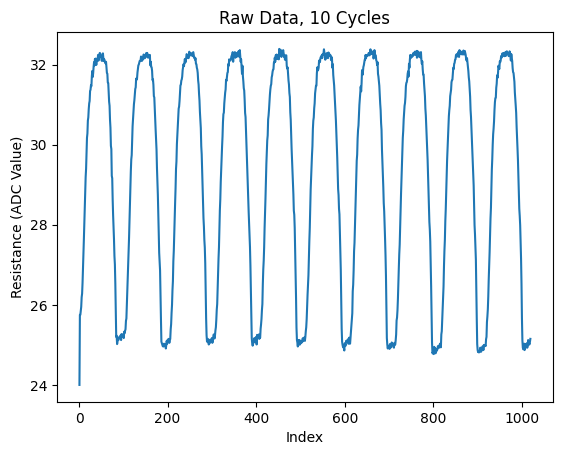

In [35]:
# df.plot(x='Cycle', y='Reading',c='Position',colormap='jet', kind='scatter')
# plt.scatter(df.index, df['Reading'], c=df['Position'], cmap='viridis',s=3)
plt.plot(df.index, df['Reading'])
plt.title('Raw Data, 10 Cycles')
plt.xlabel('Index')
plt.ylabel('Resistance (ADC Value)')

In [36]:
df['Position_Gradient'] = np.gradient(df['Position'])
df['Direction'] = df['Position_Gradient'] > 0
df.head()

,Cycle,Position,Reading,Position_Gradient,Direction
1,0,-1,24.00,-12.0,False
2,0,-13,25.75,-12.5,False
3,0,-26,25.75,-13.0,False
4,0,-39,25.86,-12.5,False
5,0,-51,25.95,-12.5,False


,Cycle,Position,Reading,Position_Gradient,Direction
1,0,-1,24.00,-12.0,False
2,0,-13,25.75,-12.5,False
3,0,-26,25.75,-13.0,False
4,0,-39,25.86,-12.5,False
5,0,-51,25.95,-12.5,False


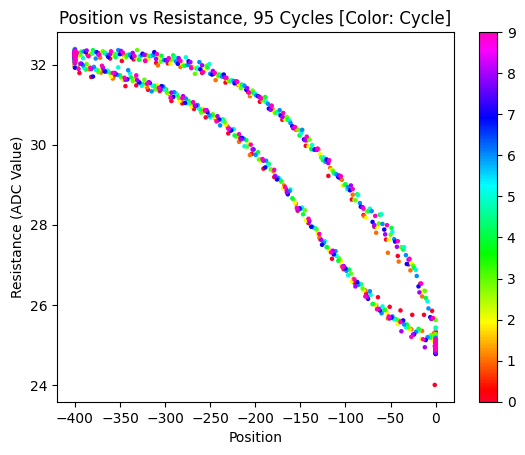

In [39]:
df_plot = df[df['Cycle'] >= 0]
plt.scatter(df_plot['Position'], df_plot['Reading'], c=df_plot['Cycle'], cmap='gist_rainbow',s=5)
plt.title('Position vs Resistance, 10 Cycles [Color: Cycle]')
plt.xlabel('Position')
plt.ylabel('Resistance (ADC Value)')
plt.colorbar()
df_plot.head()